# Transfer Learning Inception V3 - TensorFlow 2

## Import Packages

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.inception_v3 import InceptionV3 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
print(tf.__version__)

2.1.2


## Load Data

In [23]:
train_path = 'food_data/train'
valid_path = 'food_data/val'

In [24]:
IMAGE_SIZE = [200, 200]

In [25]:
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [26]:
folders = glob(train_path + '/*')
folders

['food_data/train/food', 'food_data/train/nonfood']

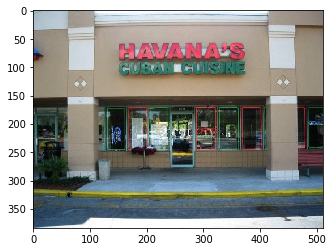

In [28]:
# Test random image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

## Build Model

Load pretrained model weights

In [13]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [14]:
# freeze pretrained model weights
ptm.trainable = False

In [16]:
ptm.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
K = len(folders) # number of classes
x = Flatten()(ptm.output) # flatten output of pretrained model
x = Dense(K, activation='softmax')(x)

In [18]:
model = Model(inputs=ptm.input, outputs=x)

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [29]:
# create image data generator instance
gen_train = ImageDataGenerator(
                            rotation_range=20,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            preprocessing_function=preprocess_input # apply vgg preprocessing 
                        )
gen_test = ImageDataGenerator(
                                preprocessing_function=preprocess_input # only apply preprocessing for test
                            )

In [30]:
batch_size = 128

#create generators

train_generator = gen_train.flow_from_directory(
                        train_path,
                        shuffle=True,
                        target_size=IMAGE_SIZE,
                        batch_size=batch_size)
valid_generator = gen_test.flow_from_directory(
                        valid_path,
                        target_size=IMAGE_SIZE,
                        batch_size=batch_size)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
model.compile(
  loss='categorical_crossentropy', # use categorical loss instead of spare when using with generator
  optimizer='adam',
  metrics=['accuracy']
)

## Train

In [32]:
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 24 steps, validate for 8 steps
Epoch 1/10
24/24 [==============================] - 105s 4s/step - loss: 3.9780 - accuracy: 0.7643 - val_loss: 0.0856 - val_accuracy: 0.9790
Epoch 2/10
24/24 [==============================] - 49s 2s/step - loss: 0.3448 - accuracy: 0.9723 - val_loss: 0.1914 - val_accuracy: 0.9650
Epoch 3/10
24/24 [==============================] - 49s 2s/step - loss: 0.2721 - accuracy: 0.9740 - val_loss: 0.0915 - val_accuracy: 0.9810
Epoch 4/10
24/24 [==============================] - 49s 2s/step - loss: 0.2192 - accuracy: 0.9763 - val_loss: 0.0503 - val_accuracy: 0.9910
Epoch 5/10
24/24 [==============================] - 49s 2s/step - loss: 0.1357 - accuracy: 0.9810 - val_loss: 0.0455 - val_accuracy: 0.9870
Epoch 6/10
24/24 [==============================] - 49s 2s/step - loss: 0.1204 - accuracy: 0.9877 - val_loss: 0.0424 - val_accuracy:

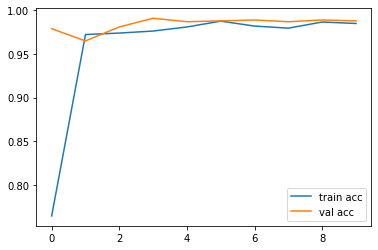

In [33]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend();

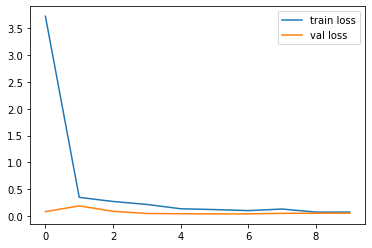

In [34]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend();

## Evaluate

create a 2nd train generator which does not use data augmentation to get the true train accuracy

In [35]:
train_generator2 = gen_test.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
model.evaluate_generator(
    train_generator2,
    steps=int(np.ceil(len(image_files) / batch_size)))

Found 3000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


[0.02044078930885007, 0.994]